### Este é um projeto para a matéria "**Algoritmos de Inteligência Artificial para classificação**" da Infnet.
### Feito 100% por **Everton Vanoni Fernandes** com o conhecimento adquirido nas aulas ao vivo, no curso de Kaggle, e pesquisas no google em expecificos pontos.

In [26]:
# Importações que vamos usar neste arquivo.
from kagglehub import KaggleDatasetAdapter, load_dataset
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer

### 1. Carregamento do data set

Para facilitar, e não precisar do arquivo de dataset baixado no mesmo local deste arquivo, ou usar o drive que necessita de um login, vamos usar o kagglehub.

<ipython-input-27-10b097a2f089>:3: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = load_dataset(KaggleDatasetAdapter.PANDAS, "rajyellow46/wine-quality", file_path)


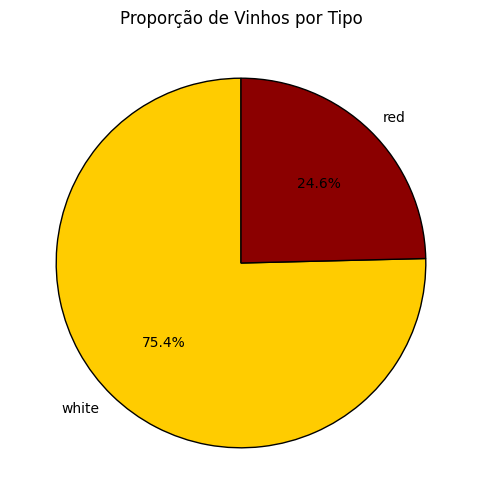

In [27]:
file_path = "winequalityN.csv"

df = load_dataset(KaggleDatasetAdapter.PANDAS, "rajyellow46/wine-quality", file_path)

# Cria um gráfico pizza apenas para visualizar o resultado. E mostrar a porcentagem de cada tipo de vinho.
wine_counts = df['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    wine_counts,
    labels=wine_counts.index,  # Usa os próprios tipos de vinho como rótulos
    autopct='%1.1f%%',
    colors=['#ffcc00', '#8b0000'],  # Define cores para vinhos brancos e tintos
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Proporção de Vinhos por Tipo")
plt.show()

### 2. Filtrar apenas por vinhos do tipo "branco"

Este dataset contem 75.4% de vinhos brancos, e ~24.6% de vinhos vermelhos, mas só estamos interessados nos vinhos do tipo branco, então vamos filtrar na celula abaixo.

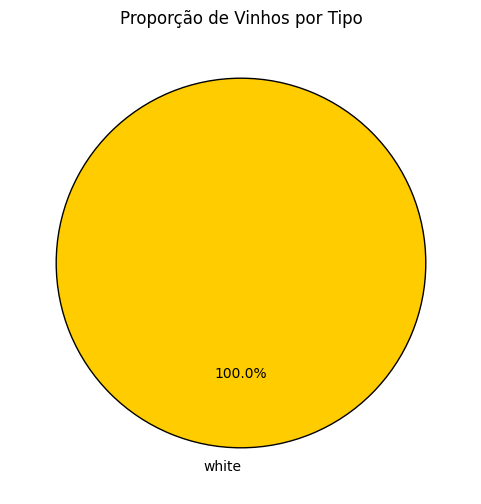

In [28]:
df_white_wine = df[df['type'] == 'white']


# Cria um gráfico pizza apenas para visualizar o resultado do filtro.
white_wine_counts = df_white_wine['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    white_wine_counts,
    labels=white_wine_counts.index,  # Usa os próprios tipos de vinho como rótulos
    autopct='%1.1f%%',
    colors=['#ffcc00', '#8b0000'],  # Define cores para vinhos brancos e tintos
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Proporção de Vinhos por Tipo")
plt.show()

### 3. Adicionando a variavel "opinion"

Temos o seguinte requisito para este projeto:

> criar variavel “opinion” onde o valor deve ser 0 caso o “quality” seja menor ou igual a 5, se nao deve ser 1

Visto isso, vamos adicionar essa uma nova coluna ao dataset, onde:
- Se a qualidade do vinho (quality) for menor ou igual a 5, opinion será 0 (ruim).
- Se a qualidade for maior que 5, opinion será 1 (bom).

In [29]:
df_white_wine['opinion'] = (df_white_wine['quality'] >= 5).astype(int)

<ipython-input-29-f4ef4c3bd8e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_white_wine['opinion'] = (df_white_wine['quality'] >= 5).astype(int)


### 4. Analisando as variáveis presentes na base

Temos o seguinte requisito para o projeto:

> Descreva as variáveis presentes na base. Quais são as variáveis? Quais são os tipos de variáveis (discreta, categórica, contínua)? Quais são as médias e desvios padrões?

Vou estar respondendo cada pergunta junto com um "print" na celula abaixo.


In [30]:
# Quais são as variáveis?
# Como podemos ver no print abaixo, as variáveis sao:
# - type: Tipo do vinho
# - fixed acidity: Acidez fixa
# - volatile acidity: Acidez volátil
# - citric acid: Ácido cítrico
# - residual sugar: Açúcar residual
# - chlorides: Cloretos
# - free sulfur dioxide: Dióxido de enxofre livre
# - total sulfur dioxide: Dióxido de enxofre total
# - density: Densidade
# - pH: pH do vinho
# - sulphates: Sulfatos
# - alcohol: Teor alcoólico
# - quality: Qualidade do vinho (nota de 0 a 10)
# - opinion: Variável criada para classificação (0 = ruim, 1 = bom)
print("Colunas do dataset:", df_white_wine.columns.tolist())

# Quais são os tipos de variáveis (discreta, categórica, continuas)?
# categórica:
# - type: Representa o tipo de vinho (red ou white), ou seja, e categorica
# - opinion: Criamos essa coluna nova para classificarmos se tem qualidade ou nao, ou seja, e categorica tambem
# discreta:
# - quality: Representa notas de 0 a 10, sempre numeros inteiros e contaveis
# continuas:
# Todas as outras variaveis, sao numeros quebrados, ou podemos dizer decimais, do tipo float
print("\nTipos das variáveis:\n", df_white_wine.dtypes)

# Quais são as médias e desvios padrões?
# Podemos estar verificando as respostas para essa pergunta no print abaixo,
# para verificar as médias podemos estar olhando para a variavel "mean", e
# para verificar o desvio padrao olhamos para a variavel "std".
print("\nEstatísticas das variáveis numéricas:\n", df_white_wine.describe())

Colunas do dataset: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'opinion']

Tipos das variáveis:
 type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
opinion                   int64
dtype: object

Estatísticas das variáveis numéricas:
        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4890.000000       4891.000000  4896.000000     4896.000000   
mean        6.855532          0.278252     0.334250        6.393250   
std         0.843808          0.100811  

### 5. Etapas necessárias para criar um modelo de classificação eficiente

#### Antes de começar a modelagem, é essencial entender:

- O objetivo do modelo: prever se um vinho tem boa qualidade (opinion = 1) ou não (opinion = 0)
- O significado das variáveis e sua relação com a variável alvo (opinion)
- Possíveis desafios como desbalanceamento de classes, outliers e correlação entre variáveis

#### Pré-processamento dos Dados

1. Tratamento de valores faltantes

Precisamos fazer o tratamento de valores faltantes, para casos onde o valor e null, caso tenha valores null, precisamos remover, ou preencher com a media, mediana ou outro metodo.

2. Tratamento de Outliers

Precisamos identificar valores extremos nas variaveis continuas usando graficos como boxplots, e para resolver podemos fazer a remocao dos outliers ou a normalizacao dos dados.

#### Divisao entre conjunto de treino e teste

O dataset deve ser dividido em treino, e teste para avaliar o desempenho do modelo.

#### Escolha do modelo

Com os dados preparados, podemos testar diferentes algoritmos de classificacao.
Para este projeto iremos estar testando com os mesmos dados, os seguintes modelos:

- Regressão Logística
- Árvores de Decisão
- SVM (Support Vector Machine)

#### Avaliação do Modelo

Apos treinar o modelo, precisamos avaliar sua performance das seguintes formas:

1. Usar "confusion_matrix" para saber a Matriz de Confusao
2. Usar "accuracy_score" para saber a Acurácia
3. Usar "classification_report" para outras metricas importantes como precisao, recall e f1-score

#### Ajuste de Hiperparâmetros

Se os resultados nao forem satisfatorios, podemos ajustar os params do modelo usando tecnicas como:

- Grid Search: Testa combinacoes de parametros para encontrar os melhores valores.
- Random Search - Testa valores aleatorios e pode ser mais rapido.


#### Implementação e Otimização:

Se o modelo estiver satisfatorio, podemos aplicar o modelo em um pipeline para facilitar o uso em producao, e apos isso so salvar o modelo de alguma forma, como por exemplo usando o "joblib.dump(model, "wine_model.pk1")".





### 6. Preparação das variaveis


In [31]:
# separarando em x e y
target = 'opinion'
x = df_white_wine.drop([target, 'quality'], axis=1)
y = df_white_wine[[target]]

In [32]:
# separando variáveis numéricas e categóricas
cat = ['type']
num = [col for col in x.columns if col not in cat]

In [33]:
# separando treino e teste - com estratificação
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

### 7. Criação dos modelos

Vamos comecar a colocar a mão na massa criando os modelos, que vai ser o de regressão logística, arvore de decisão e SVM usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação de cada um.

#### Requisitos para cada modelo:

Precisamos calcular para a base de teste:

- [x]  i. a média e desvio da acurácia dos modelos obtidos;
- [x]  ii. a média e desvio da precisão dos modelos obtidos;
- [x]  iii. a média e desvio da recall dos modelos obtidos;
- [x]  iv. a média e desvio do f1-score dos modelos obtidos.




In [34]:
# criando um pipe de processamento
preprocessor = ColumnTransformer([
    ('category', OneHotEncoder(drop='first'), cat),
    ('numeric', RobustScaler(), num)
])

In [35]:
# criando os pipes para cada modelo
logistic_regression_pipe = Pipeline([
    ('transformer', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')), # Trata valorer NaN
    ('selector', SelectKBest(f_classif)),
    ('model', LogisticRegression(solver='saga'))
])

decision_tree_pipe = Pipeline([
    ('transformer', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')), # Trata valorer NaN
    ('selector', SelectKBest(f_classif)),
    ('model', DecisionTreeClassifier(random_state=5))
])

svc_pipe = Pipeline([
    ('transformer', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')), # Trata valorer NaN
    ('selector', SelectKBest(f_classif)),
    ('svc', SVC(random_state=2, probability=True))
])

In [36]:
# configurando o espaço de busca
params_grid_logistic_regression = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight': ['balanced', None],
    'selector__k': range(1, 11)
}

params_grid_decision_three = {
    'model__max_depth': range(2, 11),
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': ['balanced', None],
    'selector__k': range(1, 11)
}

params_grid_svc = {
    'selector__k': range(1, 11)
}

In [37]:
# configuranco o amostrador - estratificado
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

In [38]:
# configura um buscador aleatório - logistic regression
random_search_logistic_regression = RandomizedSearchCV(
    estimator=logistic_regression_pipe,
    param_distributions=params_grid_logistic_regression,
    n_iter=50,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

# configura um buscador aleatório - decision three
random_search_decision_three = RandomizedSearchCV(
    estimator=decision_tree_pipe,
    param_distributions=params_grid_decision_three,
    n_iter=50,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

# configura um buscador aleatório - svm
random_search_svm = RandomizedSearchCV(
    estimator=svc_pipe,
    param_distributions=params_grid_svc,
    n_iter=50,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

In [39]:
# busca os melhores params para logistic regression
random_search_logistic_regression.fit(x_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 1/10; 1/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 2/10; 1/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 2/10; 1/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 3/10; 1/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 3/10; 1/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 4/10; 1/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 1/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 5/10; 1/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 5/10; 1/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 6/10; 1/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 6/10; 1/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 7/10; 1/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 7/10; 1/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 8/10; 1/50] START model__C=0.01, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 1/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 9/10; 1/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 9/10; 1/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=0.982 total time=   0.1s
[CV 10/10; 1/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 10/10; 1/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=0.982 total time=   0.1s
[CV 1/10; 2/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 2/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.852 total time=   0.1s
[CV 2/10; 2/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 2/10; 2/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.833 total time=   0.1s
[CV 3/10; 2/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 3/10; 2/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.862 total time=   0.1s
[CV 4/10; 2/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 4/10; 2/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 2/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.859 total time=   0.1s
[CV 6/10; 2/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 6/10; 2/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.838 total time=   0.1s
[CV 7/10; 2/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 7/10; 2/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.833 total time=   0.1s
[CV 8/10; 2/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 8/10; 2/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 2/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.837 total time=   0.1s
[CV 10/10; 2/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 10/10; 2/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.820 total time=   0.1s
[CV 1/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8
[CV 1/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8;, score=0.867 total time=   0.1s
[CV 2/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3

[CV 2/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8;, score=0.840 total time=   0.1s
[CV 3/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8
[CV 3/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8;, score=0.838 total time=   0.1s
[CV 4/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8
[CV 4/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8;, score=0.864 total time=   0.1s
[CV 5/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8;, score=0.851 total time=   0.1s
[CV 6/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8
[CV 6/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8;, score=0.863 total time=   0.1s
[CV 7/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8
[CV 7/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8;, score=0.860 total time=   0.1s
[CV 8/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8;, score=0.886 total time=   0.1s
[CV 9/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8
[CV 9/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8;, score=0.852 total time=   0.1s
[CV 10/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=8;, score=0.852 total time=   0.1s
[CV 1/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 1/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.868 total time=   0.1s
[CV 2/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.844 total time=   0.1s
[CV 3/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 3/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.853 total time=   0.1s
[CV 4/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 4/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.852 total time=   0.1s
[CV 5/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 5/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.865 total time=   0.1s
[CV 6/10; 4/50] START model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.868 total time=   0.1s
[CV 7/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 7/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.874 total time=   0.0s
[CV 8/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 8/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.877 total time=   0.1s
[CV 9/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 9/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.835 total time=   0.1s
[CV 10/10; 4/50] START model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.825 total time=   0.1s
[CV 1/10; 5/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1
[CV 1/10; 5/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1;, score=0.820 total time=   0.0s
[CV 2/10; 5/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1
[CV 2/10; 5/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1;, score=0.813 total time=   0.0s
[CV 3/10; 5/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1
[CV 3/10; 5/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1;, score=0.841 total time=

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 5/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1;, score=0.838 total time=   0.1s
[CV 7/10; 5/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1
[CV 7/10; 5/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1;, score=0.833 total time=   0.0s
[CV 8/10; 5/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1
[CV 8/10; 5/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1;, score=0.809 total time=   0.0s
[CV 9/10; 5/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1
[CV 9/10; 5/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=1;, score=0.818 total 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 6/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.979 total time=   0.1s
[CV 2/10; 6/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 2/10; 6/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.1s
[CV 3/10; 6/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 3/10; 6/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.1s
[CV 4/10; 6/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 6/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.1s
[CV 5/10; 6/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 5/10; 6/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.1s
[CV 6/10; 6/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 6/10; 6/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.1s
[CV 7/10; 6/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 6/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.1s
[CV 8/10; 6/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 8/10; 6/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.1s
[CV 9/10; 6/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 9/10; 6/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.982 total time=   0.1s
[CV 10/10; 6/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3

[CV 10/10; 6/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.982 total time=   0.1s
[CV 1/10; 7/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9
[CV 1/10; 7/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9;, score=0.979 total time=   0.1s
[CV 2/10; 7/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9
[CV 2/10; 7/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 3/10; 7/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9
[CV 3/10; 7/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 4/10; 7/50] START model__C=10, model__class_weight=None, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 7/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 5/10; 7/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9
[CV 5/10; 7/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 6/10; 7/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 7/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9;, score=0.979 total time=   0.1s
[CV 7/10; 7/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9
[CV 7/10; 7/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9;, score=0.978 total time=   0.1s
[CV 8/10; 7/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9
[CV 8/10; 7/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 9/10; 7/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 7/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9;, score=0.982 total time=   0.1s
[CV 10/10; 7/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9
[CV 10/10; 7/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=9;, score=0.984 total time=   0.1s
[CV 1/10; 8/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 8/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.979 total time=   0.1s
[CV 2/10; 8/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 2/10; 8/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.1s
[CV 3/10; 8/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 3/10; 8/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.1s
[CV 4/10; 8/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 4/10; 8/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.1s
[CV 5/10; 8/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 5/10; 8/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.1s
[CV 6/10; 8/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 6/10; 8/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.1s
[CV 7/10; 8/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 8/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.978 total time=   0.1s
[CV 8/10; 8/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 8/10; 8/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.1s
[CV 9/10; 8/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 9/10; 8/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.982 total time=   0.1s
[CV 10/10; 8/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 10/10; 8/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.982 total time=   0.1s
[CV 1/10; 9/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 1/10; 9/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.0s
[CV 2/10; 9/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 2/10; 9/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.0s
[CV 3/10; 9/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 3/10; 9/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.0s
[CV 4/10; 9/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 4/10; 9/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.0s
[CV 5/10; 9/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 5/10; 9/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.0s
[CV 6/10; 9/50] START model__C=0.001, model__class

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 9/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.0s
[CV 9/10; 9/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 9/10; 9/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.982 total time=   0.0s
[CV 10/10; 9/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 10/10; 9/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.982 total time=   0.0s
[CV 1/10; 10/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 1/10; 10/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.979 total time=   0.1s
[CV 2/10; 10/50] START model__C=

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 10/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 3/10; 10/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 3/10; 10/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 4/10; 10/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 4/10; 10/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 5/10; 10/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 10/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 6/10; 10/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 6/10; 10/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 7/10; 10/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 7/10; 10/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 8/10; 10/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 10/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 9/10; 10/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 9/10; 10/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.982 total time=   0.1s
[CV 10/10; 10/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 10/10; 10/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.982 total time=   0.1s
[CV 1/10; 11/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 1/10; 11/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.981 total time=   0.0s
[CV 2/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 11/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.981 total time=   0.0s
[CV 3/10; 11/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 3/10; 11/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.981 total time=   0.0s
[CV 4/10; 11/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 4/10; 11/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.981 total time=   0.0s
[CV 5/10; 11/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 5/10; 11/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.981 total time=   0.0s
[CV 6/10; 11/50] START model__C=0.01, model

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

[CV 8/10; 11/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.981 total time=   0.0s
[CV 9/10; 11/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 9/10; 11/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.982 total time=   0.0s
[CV 10/10; 11/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 10/10; 11/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.982 total time=   0.0s
[CV 1/10; 12/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3
[CV 1/10; 12/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.979 total time=   0.0s
[CV 2/10; 12/50] START model__C=10, model__clas

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 12/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 4/10; 12/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3
[CV 4/10; 12/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 5/10; 12/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3
[CV 5/10; 12/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 6/10; 12/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3
[CV 6/10; 12/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.979 total time=   0.0s
[CV 7/10; 12/50] START model__C=10, model__class_weight=None, mo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 12/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 9/10; 12/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3
[CV 9/10; 12/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.982 total time=   0.0s
[CV 10/10; 12/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3
[CV 10/10; 12/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.982 total time=   0.0s
[CV 1/10; 13/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 1/10; 13/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=0.865 total time=   0.1s
[CV 2/10; 13/50] START model__C=0.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 13/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=0.822 total time=   0.1s
[CV 3/10; 13/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 3/10; 13/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=0.829 total time=   0.0s
[CV 4/10; 13/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 4/10; 13/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=0.861 total time=   0.1s
[CV 5/10; 13/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 5/10; 13/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 13/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=0.841 total time=   0.1s
[CV 7/10; 13/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 7/10; 13/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=0.857 total time=   0.0s
[CV 8/10; 13/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 8/10; 13/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=0.845 total time=   0.0s
[CV 9/10; 13/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 9/10; 13/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 14/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.868 total time=   0.1s
[CV 5/10; 14/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 5/10; 14/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.856 total time=   0.1s
[CV 6/10; 14/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 6/10; 14/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.871 total time=   0.0s
[CV 7/10; 14/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 7/10; 14/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.856 total time=   0.0s
[CV 8/10; 14/50

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 14/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.883 total time=   0.0s
[CV 9/10; 14/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 9/10; 14/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.851 total time=   0.1s
[CV 10/10; 14/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 10/10; 14/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.851 total time=   0.1s
[CV 1/10; 15/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 1/10; 15/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.979 total time=   0.0s
[CV 2/10; 15/50] START 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 15/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.1s
[CV 3/10; 15/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 3/10; 15/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.1s
[CV 4/10; 15/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 4/10; 15/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.0s
[CV 5/10; 15/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 5/10; 15/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.0s
[CV 6/10; 15/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 15/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.1s
[CV 8/10; 15/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 8/10; 15/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.0s
[CV 9/10; 15/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 9/10; 15/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.982 total time=   0.1s
[CV 10/10; 15/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 10/10; 15/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.982 total time=   0.1s
[CV 1/10; 16/50] START model__C=0.1, model__clas

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 16/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 2/10; 16/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 2/10; 16/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 3/10; 16/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 3/10; 16/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 4/10; 16/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 4/10; 16/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.982 total time=   0.0s
[CV 5/10; 16/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 16/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.979 total time=   0.0s
[CV 7/10; 16/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 7/10; 16/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 8/10; 16/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 8/10; 16/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 9/10; 16/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 9/10; 16/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.982 total time=   0.0s
[CV 10/10; 16/50] START model__C=0.1, model__class

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 17/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.854 total time=   0.0s
[CV 2/10; 17/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 2/10; 17/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.835 total time=   0.0s
[CV 3/10; 17/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 3/10; 17/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.851 total time=   0.0s
[CV 4/10; 17/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 4/10; 17/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.829 total time=   0.0s
[CV 5/10; 17/50

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 17/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.843 total time=   0.1s
[CV 7/10; 17/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 7/10; 17/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.859 total time=   0.0s
[CV 8/10; 17/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 8/10; 17/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.831 total time=   0.0s
[CV 9/10; 17/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 9/10; 17/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.836 total time=   0.0s
[CV 10/10; 17/5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 18/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[CV 2/10; 18/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 2/10; 18/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[CV 3/10; 18/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 3/10; 18/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[CV 4/10; 18/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 4/10; 18/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 18/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[CV 8/10; 18/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 8/10; 18/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[CV 9/10; 18/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 9/10; 18/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.982 total time=   0.0s
[CV 10/10; 18/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 10/10; 18/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.9

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.851 total time=   0.1s
[CV 6/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 6/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.862 total time=   0.1s
[CV 7/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 7/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.858 total time=   0.0s
[CV 8/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 8/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.884 total time=   0.0s
[CV 9/10; 19/50] START model__C=10, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.850 total time=   0.1s
[CV 10/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 10/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.842 total time=   0.1s
[CV 1/10; 20/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 1/10; 20/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.869 total time=   0.0s
[CV 2/10; 20/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 2/10; 20/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.822 total time=   0.1s
[CV 3/10; 20/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 3/10; 20/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.830 total time=   0.0s
[CV 4/10; 20/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 4/10; 20/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.861 total time=   0.0s
[CV 5/10; 20/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 5/10; 20/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.847 total time=   0.0s
[CV 6/10; 20/50] START model__C=1, m

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 20/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.857 total time=   0.1s
[CV 8/10; 20/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 8/10; 20/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.882 total time=   0.1s
[CV 9/10; 20/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 9/10; 20/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.847 total time=   0.1s
[CV 10/10; 20/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 20/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.844 total time=   0.1s
[CV 1/10; 21/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 1/10; 21/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.979 total time=   0.1s
[CV 2/10; 21/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 2/10; 21/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.981 total time=   0.1s
[CV 3/10; 21/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 21/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.981 total time=   0.1s
[CV 4/10; 21/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 4/10; 21/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.981 total time=   0.1s
[CV 5/10; 21/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 5/10; 21/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.981 total time=   0.1s
[CV 6/10; 21/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 6/10; 21/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.981 total time=   0.1s
[CV 7/10; 21/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 21/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.981 total time=   0.1s
[CV 8/10; 21/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 8/10; 21/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.981 total time=   0.1s
[CV 9/10; 21/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 9/10; 21/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.982 total time=   0.1s
[CV 10/10; 21/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 21/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.982 total time=   0.1s
[CV 1/10; 22/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1
[CV 1/10; 22/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.1s
[CV 2/10; 22/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1
[CV 2/10; 22/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.1s
[CV 3/10; 22/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1
[CV 3/10; 22/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.1s
[CV 4/10; 22/50] START model__C=0.1, model__class

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 22/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.1s
[CV 5/10; 22/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1
[CV 5/10; 22/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.1s
[CV 6/10; 22/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1
[CV 6/10; 22/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1;, score=0.979 total time=   0.0s
[CV 7/10; 22/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1
[CV 7/10; 22/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.1s
[CV 8/10; 22/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 22/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.1s
[CV 9/10; 22/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1
[CV 9/10; 22/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1;, score=0.982 total time=   0.1s
[CV 10/10; 22/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1
[CV 10/10; 22/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=1;, score=0.982 total time=   0.1s
[CV 1/10; 23/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 1/10; 23/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 2/10; 23/50] START model__C=

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 23/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 3/10; 23/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 3/10; 23/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 4/10; 23/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 4/10; 23/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 5/10; 23/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 23/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 6/10; 23/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 6/10; 23/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 7/10; 23/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 7/10; 23/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 8/10; 23/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 23/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 9/10; 23/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 9/10; 23/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.982 total time=   0.1s
[CV 10/10; 23/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 10/10; 23/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.982 total time=   0.1s
[CV 1/10; 24/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 24/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.869 total time=   0.1s
[CV 2/10; 24/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 2/10; 24/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.846 total time=   0.1s
[CV 3/10; 24/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 3/10; 24/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.846 total time=   0.1s
[CV 4/10; 24/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 24/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.861 total time=   0.1s
[CV 5/10; 24/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 5/10; 24/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.857 total time=   0.0s
[CV 6/10; 24/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 6/10; 24/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.878 total time=   0.0s
[CV 7/10; 24/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 7/10; 24/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.854 total time=   0.0s
[CV 8/10; 24/50] START

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 24/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.851 total time=   0.1s
[CV 10/10; 24/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 10/10; 24/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.850 total time=   0.0s
[CV 1/10; 25/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 1/10; 25/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.852 total time=   0.0s
[CV 2/10; 25/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 2/10; 25/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.835 total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 25/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.825 total time=   0.0s
[CV 5/10; 25/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 5/10; 25/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.859 total time=   0.0s
[CV 6/10; 25/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 6/10; 25/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.839 total time=   0.0s
[CV 7/10; 25/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 7/10; 25/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.857 total 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 25/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.836 total time=   0.0s
[CV 10/10; 25/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2
[CV 10/10; 25/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=2;, score=0.814 total time=   0.0s
[CV 1/10; 26/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=9
[CV 1/10; 26/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=9;, score=0.869 total time=   0.0s
[CV 2/10; 26/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=9
[CV 2/10; 26/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=9;, scor

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 26/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=9;, score=0.891 total time=   0.1s
[CV 9/10; 26/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=9
[CV 9/10; 26/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=9;, score=0.844 total time=   0.0s
[CV 10/10; 26/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=9
[CV 10/10; 26/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=9;, score=0.842 total time=   0.0s
[CV 1/10; 27/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 1/10; 27/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.979 total time=

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 27/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 3/10; 27/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 3/10; 27/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 4/10; 27/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 4/10; 27/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 5/10; 27/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 27/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 6/10; 27/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 6/10; 27/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 7/10; 27/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 7/10; 27/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.978 total time=   0.1s
[CV 8/10; 27/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 27/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 9/10; 27/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 9/10; 27/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.982 total time=   0.1s
[CV 10/10; 27/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7
[CV 10/10; 27/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=7;, score=0.984 total time=   0.1s
[CV 1/10; 28/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 28/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.852 total time=   0.0s
[CV 2/10; 28/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 2/10; 28/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.835 total time=   0.0s
[CV 3/10; 28/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 3/10; 28/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.851 total time=   0.0s
[CV 4/10; 28/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 4/10; 28/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.825 total time=   0.0s
[CV 5/10; 28/50] START model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 28/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.839 total time=   0.1s
[CV 7/10; 28/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 7/10; 28/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.857 total time=   0.0s
[CV 8/10; 28/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 8/10; 28/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.831 total time=   0.0s
[CV 9/10; 28/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 9/10; 28/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.836 total time=   0.0s
[CV 10/10; 28/50] START model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.979 total time=   0.1s
[CV 2/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 2/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 3/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 3/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 4/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 4/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 5/10

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 6/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 6/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.979 total time=   0.1s
[CV 7/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 7/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.979 total time=   0.1s
[CV 8/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.981 total time=   0.1s
[CV 9/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 9/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.982 total time=   0.1s
[CV 10/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 10/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.982 total time=   0.1s
[CV 1/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 1/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.979 total time=   0.1s
[CV 2/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 2/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 3/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 3/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 4/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 5/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 5/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 6/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 6/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 7/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.978 total time=   0.1s
[CV 8/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 8/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 9/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 9/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.982 total time=   0.1s
[CV 10/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.984 total time=   0.1s
[CV 1/10; 31/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1
[CV 1/10; 31/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1;, score=0.820 total time=   0.0s
[CV 2/10; 31/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1
[CV 2/10; 31/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1;, score=0.813 total time=   0.0s
[CV 3/10; 31/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1
[CV 3/10; 31/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1;, score=0.841 total time=   0.0s
[CV 4/10; 31/50] START mod

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 31/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1;, score=0.859 total time=   0.0s
[CV 6/10; 31/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1
[CV 6/10; 31/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1;, score=0.838 total time=   0.0s
[CV 7/10; 31/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1
[CV 7/10; 31/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1;, score=0.833 total time=   0.0s
[CV 8/10; 31/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1
[CV 8/10; 31/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1;, score=0.809 total time=   0.0s
[CV 9/10; 31/50] START model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 31/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=1;, score=0.798 total time=   0.0s
[CV 1/10; 32/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 1/10; 32/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.869 total time=   0.1s
[CV 2/10; 32/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 2/10; 32/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.822 total time=   0.1s
[CV 3/10; 32/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 3/10; 32/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.830 total time=   0.1s
[CV 4/10; 32/50] START model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 32/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.862 total time=   0.1s
[CV 5/10; 32/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 5/10; 32/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.847 total time=   0.0s
[CV 6/10; 32/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 6/10; 32/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.862 total time=   0.0s
[CV 7/10; 32/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 7/10; 32/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.857 total time=   0.1s
[CV 8/10; 32/50] START model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 32/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.847 total time=   0.1s
[CV 10/10; 32/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 10/10; 32/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.846 total time=   0.0s
[CV 1/10; 33/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8
[CV 1/10; 33/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8;, score=0.979 total time=   0.1s
[CV 2/10; 33/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8
[CV 2/10; 33/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 3/10; 33/50] START model__C=0.1, mo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 33/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 4/10; 33/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8
[CV 4/10; 33/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8;, score=0.982 total time=   0.1s
[CV 5/10; 33/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8
[CV 5/10; 33/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 6/10; 33/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 33/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 7/10; 33/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8
[CV 7/10; 33/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 8/10; 33/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 33/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 9/10; 33/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8
[CV 9/10; 33/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8;, score=0.982 total time=   0.1s
[CV 10/10; 33/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8
[CV 10/10; 33/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=8;, score=0.982 total time=   0.1s
[CV 1/10; 34/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 34/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.869 total time=   0.0s
[CV 2/10; 34/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 2/10; 34/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.822 total time=   0.0s
[CV 3/10; 34/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 3/10; 34/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.830 total time=   0.0s
[CV 4/10; 34/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 4/10; 34/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.862 total time=   0.0s
[CV 5/10; 34/50] START model__C=10, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 34/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.862 total time=   0.0s
[CV 7/10; 34/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 7/10; 34/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.857 total time=   0.0s
[CV 8/10; 34/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 8/10; 34/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.882 total time=   0.1s
[CV 9/10; 34/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 9/10; 34/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.847 total time=   0.0s
[CV 10/10; 34/50] START model__C=10,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 34/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.846 total time=   0.1s
[CV 1/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10
[CV 1/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10;, score=0.862 total time=   0.0s
[CV 2/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10
[CV 2/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10;, score=0.853 total time=   0.1s
[CV 3/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10
[CV 3/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selec

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10;, score=0.841 total time=   0.1s
[CV 5/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10
[CV 5/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10;, score=0.883 total time=   0.1s
[CV 6/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10
[CV 6/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10;, score=0.871 total time=   0.1s
[CV 7/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10;, score=0.858 total time=   0.1s
[CV 8/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10
[CV 8/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10;, score=0.852 total time=   0.1s
[CV 9/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10
[CV 9/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10;, score=0.849 total time=   0.1s
[CV 10/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=10;, score=0.829 total time=   0.1s
[CV 1/10; 36/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 1/10; 36/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.840 total time=   0.1s
[CV 2/10; 36/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 2/10; 36/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.830 total time=   0.1s
[CV 3/10; 36/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 36/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.834 total time=   0.0s
[CV 4/10; 36/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 4/10; 36/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.844 total time=   0.0s
[CV 5/10; 36/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 5/10; 36/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.860 total time=   0.0s
[CV 6/10; 36/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 6/10; 36/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 8/10; 36/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.838 total time=   0.1s
[CV 9/10; 36/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 9/10; 36/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.808 total time=   0.1s
[CV 10/10; 36/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 10/10; 36/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.822 total time=   0.0s
[CV 1/10; 37/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 1/10; 37/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 37/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.839 total time=   0.1s
[CV 3/10; 37/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 3/10; 37/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.846 total time=   0.0s
[CV 4/10; 37/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 4/10; 37/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.840 total time=   0.0s
[CV 5/10; 37/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 5/10; 37/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, scor

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 37/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.841 total time=   0.1s
[CV 8/10; 37/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 8/10; 37/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.859 total time=   0.0s
[CV 9/10; 37/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 9/10; 37/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.836 total time=   0.1s
[CV 10/10; 37/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 10/10; 37/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, sc

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3

[CV 2/10; 38/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.0s
[CV 3/10; 38/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 3/10; 38/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.0s
[CV 4/10; 38/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 4/10; 38/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.0s
[CV 5/10; 38/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 5/10; 38/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.0s
[CV 6/10; 38/50] START model__C=0.00

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 38/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.0s
[CV 8/10; 38/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 8/10; 38/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=0.981 total time=   0.0s
[CV 9/10; 38/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 9/10; 38/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=0.982 total time=   0.0s
[CV 10/10; 38/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 10/10; 38/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=0.982 total time=   0.0s
[CV 1/10; 39/50] START model__C=0.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 39/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.846 total time=   0.1s
[CV 3/10; 39/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 3/10; 39/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.846 total time=   0.1s
[CV 4/10; 39/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 4/10; 39/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.861 total time=   0.0s
[CV 5/10; 39/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 5/10; 39/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.857 total time=   0.0s
[CV 6/10; 39/50

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 39/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.878 total time=   0.0s
[CV 7/10; 39/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 7/10; 39/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.854 total time=   0.0s
[CV 8/10; 39/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 8/10; 39/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.889 total time=   0.1s
[CV 9/10; 39/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 9/10; 39/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.851 total time=   0.0s
[CV 10/10; 39/5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 40/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.852 total time=   0.1s
[CV 2/10; 40/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 2/10; 40/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.835 total time=   0.0s
[CV 3/10; 40/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 3/10; 40/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.851 total time=   0.0s
[CV 4/10; 40/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 4/10; 40/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, scor

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 40/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.839 total time=   0.0s
[CV 7/10; 40/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 7/10; 40/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.857 total time=   0.0s
[CV 8/10; 40/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 8/10; 40/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.831 total time=   0.0s
[CV 9/10; 40/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 9/10; 40/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, scor

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 40/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.814 total time=   0.1s
[CV 1/10; 41/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 1/10; 41/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.857 total time=   0.2s
[CV 2/10; 41/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 2/10; 41/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.847 total time=   0.1s
[CV 3/10; 41/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 3/10; 41/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.850 total time=   0.1s
[CV 4/10; 41/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 41/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.836 total time=   0.1s
[CV 5/10; 41/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 5/10; 41/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.866 total time=   0.1s
[CV 6/10; 41/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 6/10; 41/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.830 total time=   0.1s
[CV 7/10; 41/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 7/10; 41/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.849 total time=   0.1s
[CV 8/10; 41/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 8/10; 41/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.851 total time=   0.1s
[CV 9/10; 41/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 41/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.842 total time=   0.1s
[CV 10/10; 41/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 10/10; 41/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.824 total time=   0.1s
[CV 1/10; 42/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 1/10; 42/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 2/10; 42/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 2/10; 42/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 3/10; 42/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 3/10; 42/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.0s
[CV 4/10; 42/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 4/10; 42/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.0s
[CV 5/10; 42/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 5/10; 42/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 42/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 8/10; 42/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 8/10; 42/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.1s
[CV 9/10; 42/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 9/10; 42/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.982 total time=   0.1s
[CV 10/10; 42/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 10/10; 42/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=0.9

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 43/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.1s
[CV 2/10; 43/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4
[CV 2/10; 43/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.1s
[CV 3/10; 43/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4
[CV 3/10; 43/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.1s
[CV 4/10; 43/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 43/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.1s
[CV 5/10; 43/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4
[CV 5/10; 43/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.1s
[CV 6/10; 43/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4
[CV 6/10; 43/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.1s
[CV 7/10; 43/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 43/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.1s
[CV 8/10; 43/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4
[CV 8/10; 43/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.1s
[CV 9/10; 43/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4
[CV 9/10; 43/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4;, score=0.982 total time=   0.1s
[CV 10/10; 43/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3

[CV 10/10; 43/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=4;, score=0.982 total time=   0.1s
[CV 1/10; 44/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 1/10; 44/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 2/10; 44/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 2/10; 44/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 3/10; 44/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 44/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 4/10; 44/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 4/10; 44/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 5/10; 44/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 5/10; 44/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 6/10; 44/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 44/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 7/10; 44/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 7/10; 44/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 8/10; 44/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 8/10; 44/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 9/10; 44/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 9/10; 44/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.982 total time=   0.1s
[CV 10/10; 44/50] START model__C=0.01, mode

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 44/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.982 total time=   0.1s
[CV 1/10; 45/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 1/10; 45/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.868 total time=   0.1s
[CV 2/10; 45/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 2/10; 45/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.844 total time=   0.1s
[CV 3/10; 45/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 45/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.853 total time=   0.1s
[CV 4/10; 45/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 4/10; 45/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.852 total time=   0.0s
[CV 5/10; 45/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 5/10; 45/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.865 total time=   0.1s
[CV 6/10; 45/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 6/10; 45/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.868 total time=   0.1s
[CV 7/10; 45/50

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 45/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.874 total time=   0.1s
[CV 8/10; 45/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 8/10; 45/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.877 total time=   0.1s
[CV 9/10; 45/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 9/10; 45/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.835 total time=   0.1s
[CV 10/10; 45/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 10/10; 45/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.825 total time=   0.1s
[CV 1/10; 46/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 46/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8;, score=0.869 total time=   0.1s
[CV 2/10; 46/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8
[CV 2/10; 46/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8;, score=0.842 total time=   0.1s
[CV 3/10; 46/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8
[CV 3/10; 46/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8;, score=0.838 total time=   0.0s
[CV 4/10; 46/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8
[CV 4/10; 46/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 46/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8;, score=0.851 total time=   0.1s
[CV 6/10; 46/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8
[CV 6/10; 46/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8;, score=0.863 total time=   0.1s
[CV 7/10; 46/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8
[CV 7/10; 46/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8;, score=0.860 total time=   0.1s
[CV 8/10; 46/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8
[CV 8/10; 46/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 46/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8;, score=0.850 total time=   0.1s
[CV 10/10; 46/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8
[CV 10/10; 46/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=8;, score=0.852 total time=   0.1s
[CV 1/10; 47/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3
[CV 1/10; 47/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3;, score=0.855 total time=   0.0s
[CV 2/10; 47/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3
[CV 2/10; 47/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3;, score=0.839 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 47/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3;, score=0.846 total time=   0.1s
[CV 4/10; 47/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3
[CV 4/10; 47/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3;, score=0.840 total time=   0.0s
[CV 5/10; 47/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3
[CV 5/10; 47/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3;, score=0.862 total time=   0.1s
[CV 6/10; 47/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3
[CV 6/10; 47/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3;, score=0.828 total time=   0.0s
[CV 7/10; 47/50] START model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 47/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3;, score=0.859 total time=   0.0s
[CV 9/10; 47/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3
[CV 9/10; 47/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3;, score=0.836 total time=   0.0s
[CV 10/10; 47/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3
[CV 10/10; 47/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=3;, score=0.820 total time=   0.1s
[CV 1/10; 48/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6
[CV 1/10; 48/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.0s
[CV 2/10; 48/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 48/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.0s
[CV 4/10; 48/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6
[CV 4/10; 48/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.0s
[CV 5/10; 48/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6
[CV 5/10; 48/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.0s
[CV 6/10; 48/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6
[CV 6/10; 48/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6;, score=0.981

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 48/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6;, score=0.982 total time=   0.1s
[CV 10/10; 48/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6
[CV 10/10; 48/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=6;, score=0.982 total time=   0.1s
[CV 1/10; 49/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5
[CV 1/10; 49/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5;, score=0.979 total time=   0.1s
[CV 2/10; 49/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5
[CV 2/10; 49/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 3/10; 49/50] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 49/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 4/10; 49/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5
[CV 4/10; 49/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5;, score=0.982 total time=   0.0s
[CV 5/10; 49/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5
[CV 5/10; 49/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.0s
[CV 6/10; 49/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5
[CV 6/10; 49/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5;, score=0.979 total time=   0.1s
[CV 7/10; 49/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 49/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 8/10; 49/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5
[CV 8/10; 49/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.1s
[CV 9/10; 49/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5
[CV 9/10; 49/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5;, score=0.982 total time=   0.1s
[CV 10/10; 49/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5
[CV 10/10; 49/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=5;, score=0.982 total time=   0.1s
[CV 1/10; 50/50] START model__C=0.1, model__clas

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 50/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.979 total time=   0.1s
[CV 2/10; 50/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 2/10; 50/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 3/10; 50/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 3/10; 50/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 4/10; 50/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 50/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 5/10; 50/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 5/10; 50/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 6/10; 50/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 6/10; 50/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 7/10; 50/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 50/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.979 total time=   0.1s
[CV 8/10; 50/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 8/10; 50/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 9/10; 50/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 9/10; 50/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.982 total time=   0.1s
[CV 10/10; 50/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 10/10; 50/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.982 total time=

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=5, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('category',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['type']),
                                                                              ('numeric',
                                                                               RobustScaler(),
                                                                               ['fixed '
                                                                                'acidity',
                                                                                'volatile '
                                                                                'acidity',
                                                                                'citric '
                                                                                'acid',
                                                                                'residual '
                                                                                'sugar',
                                                                                'chlorides',
                                                                                'free '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                '...
                                                                                'sulphates',
                                                                                'alcohol'])])),
                                             ('imputer', SimpleImputer()),
                                             ('selector', SelectKBest()),
                                             ('model',
                                              LogisticRegression(solver='saga'))]),
                   n_iter=50,
                   param_distributions={'model__C': [0.001, 0.01, 0.1, 1, 10],
                                        'model__class_weight': ['balanced',
                                                                None],
                                        'model__l1_ratio': [0.25, 0.5, 0.75],
                                        'model__penalty': ['l1', 'l2',
                                                           'elasticnet'],
                                        'selector__k': range(1, 11)},
                   scoring='f1', verbose=10)

In [40]:
# busca os melhores params para decision three
random_search_decision_three.fit(x_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 1/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.906 total time=   0.0s
[CV 2/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 2/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.937 total time=   0.0s
[CV 3/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 3/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.908 total time=   0.0s
[CV 4/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 4/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__m

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.900 total time=   0.0s
[CV 6/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 6/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.906 total time=   0.0s
[CV 7/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 7/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.911 total time=   0.0s
[CV 8/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 8/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.921 total time=   0.0s
[CV 9/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.906 total time=   0.0s
[CV 1/10; 2/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6
[CV 1/10; 2/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6;, score=0.982 total time=   0.0s
[CV 2/10; 2/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6
[CV 2/10; 2/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6;, score=0.978 total time=   0.0s
[CV 3/10; 2/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6
[CV 3/10; 2/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6;, score=0.971 total time=   0.1s
[CV 4/10; 2/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6
[CV 4/10; 2/50] END model__clas

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 2/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6;, score=0.978 total time=   0.0s
[CV 6/10; 2/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6
[CV 6/10; 2/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6;, score=0.973 total time=   0.0s
[CV 7/10; 2/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6
[CV 7/10; 2/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6;, score=0.979 total time=   0.0s
[CV 8/10; 2/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6
[CV 8/10; 2/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6;, score=0.976 total time=   0.0s
[CV 9/10; 2/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6
[CV 9/10; 2/50] END model__class_wei

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 2/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=6;, score=0.979 total time=   0.0s
[CV 1/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2
[CV 1/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2;, score=0.981 total time=   0.0s
[CV 2/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2
[CV 2/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2;, score=0.979 total time=   0.0s
[CV 3/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2
[CV 3/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2;, score=0.979 total time=   0.0s
[CV 4/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2
[CV 4/10; 3/50

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2;, score=0.981 total time=   0.0s
[CV 6/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2
[CV 6/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2;, score=0.981 total time=   0.0s
[CV 7/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2
[CV 7/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2;, score=0.981 total time=   0.0s
[CV 8/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2
[CV 8/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2;, score=0.976 total time=   0.0s
[CV 9/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=2
[CV 9/10; 3/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 4/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.981 total time=   0.1s
[CV 2/10; 4/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 2/10; 4/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.981 total time=   0.0s
[CV 3/10; 4/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 3/10; 4/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.981 total time=   0.0s
[CV 4/10; 4/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 4/10; 4/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.981 total time=   0.0s
[CV 5/10; 4/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 4/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.976 total time=   0.1s
[CV 8/10; 4/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 8/10; 4/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.973 total time=   0.0s
[CV 9/10; 4/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 9/10; 4/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.979 total time=   0.0s
[CV 10/10; 4/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 10/10; 4/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.982 total time=   0.0s
[CV 1/10; 5/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6
[CV 1/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 5/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6;, score=0.974 total time=   0.0s
[CV 3/10; 5/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6
[CV 3/10; 5/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6;, score=0.971 total time=   0.1s
[CV 4/10; 5/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6
[CV 4/10; 5/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6;, score=0.970 total time=   0.0s
[CV 5/10; 5/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6
[CV 5/10; 5/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6;, score=0.979 total time=   0.0s
[CV 6/10; 5/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6
[CV 6/10; 5/50] END model__class_wei

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 5/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6;, score=0.977 total time=   0.0s
[CV 8/10; 5/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6
[CV 8/10; 5/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6;, score=0.974 total time=   0.0s
[CV 9/10; 5/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6
[CV 9/10; 5/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6;, score=0.977 total time=   0.0s
[CV 10/10; 5/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6
[CV 10/10; 5/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=6;, score=0.977 total time=   0.0s
[CV 1/10; 6/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9
[CV 1/10; 6/50] END model__class_w

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 6/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9;, score=0.973 total time=   0.1s
[CV 3/10; 6/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9
[CV 3/10; 6/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9;, score=0.979 total time=   0.0s
[CV 4/10; 6/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9
[CV 4/10; 6/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9;, score=0.971 total time=   0.0s
[CV 5/10; 6/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9
[CV 5/10; 6/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9;, score=0.972 total time=   0.0s
[CV 6/10; 6/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9
[CV 6/10; 6/50] END model__class_wei

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 6/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9;, score=0.976 total time=   0.1s
[CV 8/10; 6/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9
[CV 8/10; 6/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9;, score=0.984 total time=   0.0s
[CV 9/10; 6/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9
[CV 9/10; 6/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9;, score=0.973 total time=   0.1s
[CV 10/10; 6/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9
[CV 10/10; 6/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=9;, score=0.979 total time=   0.0s
[CV 1/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7
[CV 1/10; 7/50] END model__class_w

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7;, score=0.981 total time=   0.0s
[CV 3/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7
[CV 3/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7;, score=0.981 total time=   0.0s
[CV 4/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7
[CV 4/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7;, score=0.976 total time=   0.0s
[CV 5/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7
[CV 5/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7;, score=0.973 total time=   0.0s
[CV 6/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7
[CV 6/10; 7/50] END model__class_wei

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7;, score=0.978 total time=   0.0s
[CV 9/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7
[CV 9/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7;, score=0.978 total time=   0.0s
[CV 10/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7
[CV 10/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=7;, score=0.982 total time=   0.0s
[CV 1/10; 8/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 1/10; 8/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.935 total time=   0.0s
[CV 2/10; 8/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 2/10; 8/50] END mo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 8/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.923 total time=   0.1s
[CV 4/10; 8/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 4/10; 8/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.919 total time=   0.0s
[CV 5/10; 8/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 5/10; 8/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.937 total time=   0.0s
[CV 6/10; 8/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 6/10; 8/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.911 total time=   0.0s
[CV 7/10; 8/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 8/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.932 total time=   0.0s
[CV 9/10; 8/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 9/10; 8/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.914 total time=   0.0s
[CV 10/10; 8/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 10/10; 8/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.941 total time=   0.0s
[CV 1/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 1/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.958 total time=   0.0s
[CV 2/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selecto

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.947 total time=   0.1s
[CV 4/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 4/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.915 total time=   0.0s
[CV 5/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 5/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.889 total time=   0.0s
[CV 6/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 6/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.918 total time=   0.0s
[CV 7/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_dep

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.869 total time=   0.0s
[CV 10/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 10/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.890 total time=   0.0s
[CV 1/10; 10/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1
[CV 1/10; 10/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1;, score=0.976 total time=   0.0s
[CV 2/10; 10/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1
[CV 2/10; 10/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1;, score=0.979 total time=   0.0s
[CV 3/10; 10/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selecto

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 10/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1;, score=0.981 total time=   0.0s
[CV 6/10; 10/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1
[CV 6/10; 10/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1;, score=0.978 total time=   0.0s
[CV 7/10; 10/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1
[CV 7/10; 10/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1;, score=0.976 total time=   0.0s
[CV 8/10; 10/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1
[CV 8/10; 10/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1;, score=0.979 total time=   0.0s
[CV 9/10; 10/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=1
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3;, score=0.943 total time=   0.1s
[CV 2/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3
[CV 2/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3;, score=0.918 total time=   0.0s
[CV 3/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3
[CV 3/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3;, score=0.909 total time=   0.0s
[CV 4/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3
[CV 4/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3;, score=0.932 total time=   0.0s
[CV 5/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3;, score=0.920 total time=   0.0s
[CV 7/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3
[CV 7/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3;, score=0.927 total time=   0.0s
[CV 8/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3
[CV 8/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3;, score=0.933 total time=   0.0s
[CV 9/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3
[CV 9/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=3;, score=0.927 total time=   0.0s
[CV 10/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 12/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7;, score=0.956 total time=   0.0s
[CV 2/10; 12/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7
[CV 2/10; 12/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7;, score=0.928 total time=   0.0s
[CV 3/10; 12/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7
[CV 3/10; 12/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7;, score=0.935 total time=   0.0s
[CV 4/10; 12/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7
[CV 4/10; 12/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7;, score=0.857 total time=   0.0s
[CV 5/10; 12/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 12/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7;, score=0.874 total time=   0.0s
[CV 7/10; 12/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7
[CV 7/10; 12/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7;, score=0.828 total time=   0.0s
[CV 8/10; 12/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7
[CV 8/10; 12/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7;, score=0.935 total time=   0.0s
[CV 9/10; 12/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7
[CV 9/10; 12/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=7;, score=0.897 total time=   0.0s
[CV 10/10; 12/50] START model__class_weight=balanced, model__criterion=entropy, model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 13/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7;, score=0.893 total time=   0.1s
[CV 2/10; 13/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7
[CV 2/10; 13/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7;, score=0.921 total time=   0.0s
[CV 3/10; 13/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7
[CV 3/10; 13/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7;, score=0.914 total time=   0.0s
[CV 4/10; 13/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7
[CV 4/10; 13/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7;, score=0.915 total time=   0.0s
[CV 5/10; 13/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 13/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7;, score=0.922 total time=   0.0s
[CV 7/10; 13/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7
[CV 7/10; 13/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7;, score=0.916 total time=   0.0s
[CV 8/10; 13/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7
[CV 8/10; 13/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7;, score=0.905 total time=   0.0s
[CV 9/10; 13/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7
[CV 9/10; 13/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=7;, score=0.901 total time=   0.0s
[CV 10/10; 13/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 14/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10;, score=0.981 total time=   0.1s
[CV 2/10; 14/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10
[CV 2/10; 14/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10;, score=0.981 total time=   0.0s
[CV 3/10; 14/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10
[CV 3/10; 14/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10;, score=0.978 total time=   0.0s
[CV 4/10; 14/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10
[CV 4/10; 14/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10;, score=0.979 total time=   0.0s
[CV 5/10; 14/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10
[CV 5/10; 14/50] END

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 14/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10;, score=0.981 total time=   0.1s
[CV 7/10; 14/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10
[CV 7/10; 14/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10;, score=0.984 total time=   0.1s
[CV 8/10; 14/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10
[CV 8/10; 14/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10;, score=0.978 total time=   0.1s
[CV 9/10; 14/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10
[CV 9/10; 14/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10;, score=0.978 total time=   0.1s
[CV 10/10; 14/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 14/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=10;, score=0.982 total time=   0.1s
[CV 1/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 1/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.981 total time=   0.1s
[CV 2/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 2/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.981 total time=   0.0s
[CV 3/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 3/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.981 total time=   0.0s
[CV 4/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.976 total time=   0.1s
[CV 5/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 5/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.973 total time=   0.0s
[CV 6/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 6/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.981 total time=   0.1s
[CV 7/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 7/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.984 total time=   0.0s
[CV 8/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.978 total time=   0.1s
[CV 9/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 9/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.978 total time=   0.0s
[CV 10/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 10/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.982 total time=   0.1s
[CV 1/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 1/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.979 total time=   0.1s
[CV 2/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.978 total time=   0.1s
[CV 3/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 3/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.971 total time=   0.1s
[CV 4/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 4/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.970 total time=   0.1s
[CV 5/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.978 total time=   0.1s
[CV 6/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 6/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.976 total time=   0.1s
[CV 7/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 7/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.981 total time=   0.1s
[CV 8/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 8/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.976 total time=   0.1s
[CV 9/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.978 total time=   0.1s
[CV 10/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 10/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.977 total time=   0.1s
[CV 1/10; 17/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2
[CV 1/10; 17/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2;, score=0.975 total time=   0.0s
[CV 2/10; 17/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2
[CV 2/10; 17/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2;, score=0.978 total time=   0.1s
[CV 3/10; 17/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 17/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2;, score=0.973 total time=   0.1s
[CV 4/10; 17/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2
[CV 4/10; 17/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2;, score=0.976 total time=   0.1s
[CV 5/10; 17/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2
[CV 5/10; 17/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2;, score=0.976 total time=   0.1s
[CV 6/10; 17/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2
[CV 6/10; 17/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2;, score=0.980 total time=   0.1s
[CV 7/10; 17/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 17/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2;, score=0.975 total time=   0.1s
[CV 8/10; 17/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2
[CV 8/10; 17/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2;, score=0.976 total time=   0.1s
[CV 9/10; 17/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2
[CV 9/10; 17/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2;, score=0.976 total time=   0.1s
[CV 10/10; 17/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2
[CV 10/10; 17/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=2;, score=0.978 total time=   0.1s
[CV 1/10; 18/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 18/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1;, score=0.976 total time=   0.1s
[CV 2/10; 18/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1
[CV 2/10; 18/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1;, score=0.979 total time=   0.0s
[CV 3/10; 18/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1
[CV 3/10; 18/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1;, score=0.981 total time=   0.1s
[CV 4/10; 18/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1
[CV 4/10; 18/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1;, score=0.978 total time=   0.1s
[CV 5/10; 18/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 18/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1;, score=0.981 total time=   0.1s
[CV 6/10; 18/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1
[CV 6/10; 18/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1;, score=0.978 total time=   0.1s
[CV 7/10; 18/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1
[CV 7/10; 18/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1;, score=0.975 total time=   0.0s
[CV 8/10; 18/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1
[CV 8/10; 18/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1;, score=0.978 total time=   0.1s
[CV 9/10; 18/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 18/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1;, score=0.981 total time=   0.1s
[CV 10/10; 18/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1
[CV 10/10; 18/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=1;, score=0.981 total time=   0.1s
[CV 1/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 1/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2;, score=0.976 total time=   0.1s
[CV 2/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 2/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2;, score=0.974 total time=   0.1s
[CV 3/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2;, score=0.976 total time=   0.1s
[CV 4/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 4/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2;, score=0.979 total time=   0.1s
[CV 5/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 5/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2;, score=0.975 total time=   0.0s
[CV 6/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 6/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2;, score=0.979 total time=   0.0s
[CV 7/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 7/10; 19/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2;, score=0.975 total time=   0.0s
[CV 9/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 9/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2;, score=0.976 total time=   0.0s
[CV 10/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 10/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=2;, score=0.977 total time=   0.0s
[CV 1/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8
[CV 1/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8;, score=0.979 total time=   0.0s
[CV 2/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8
[CV 2/10; 20/50] 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8;, score=0.975 total time=   0.0s
[CV 5/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8
[CV 5/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8;, score=0.973 total time=   0.0s
[CV 6/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8
[CV 6/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8;, score=0.978 total time=   0.0s
[CV 7/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8
[CV 7/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8;, score=0.973 total time=   0.0s
[CV 8/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8;, score=0.979 total time=   0.1s
[CV 10/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8
[CV 10/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=8;, score=0.979 total time=   0.0s
[CV 1/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 1/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8;, score=0.932 total time=   0.0s
[CV 2/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 2/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8;, score=0.901 total time=   0.0s
[CV 3/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8;, score=0.904 total time=   0.0s
[CV 5/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 5/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8;, score=0.916 total time=   0.0s
[CV 6/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 6/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8;, score=0.907 total time=   0.0s
[CV 7/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 7/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8;, score=0.894 total time=   0.0s
[CV 8/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8;, score=0.876 total time=   0.0s
[CV 10/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 10/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=8;, score=0.908 total time=   0.1s
[CV 1/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 1/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10;, score=0.932 total time=   0.0s
[CV 2/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 2/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10;, score=0.908 total time=   0.0s
[CV 3/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, sele

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10;, score=0.905 total time=   0.0s
[CV 5/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 5/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10;, score=0.912 total time=   0.0s
[CV 6/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 6/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10;, score=0.902 total time=   0.0s
[CV 7/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 7/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10;, score=0.903 total time=   0.0s
[CV 8/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, sel

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10;, score=0.898 total time=   0.1s
[CV 10/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 10/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=10;, score=0.927 total time=   0.0s
[CV 1/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 1/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.899 total time=   0.0s
[CV 2/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 2/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.904 total time=   0.0s
[CV 3/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.906 total time=   0.0s
[CV 5/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 5/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.944 total time=   0.0s
[CV 6/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 6/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.887 total time=   0.0s
[CV 7/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 7/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.915 total time=   0.0s
[CV 8/10; 23/50] START model__class_weight=balanced, model__criterion=entropy,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.861 total time=   0.1s
[CV 10/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 10/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.969 total time=   0.0s
[CV 1/10; 24/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10
[CV 1/10; 24/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.961 total time=   0.0s
[CV 2/10; 24/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10
[CV 2/10; 24/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.834 total time=   0.0s
[CV 3/10; 24/50] START model__class_weight=balanced, model__criterion=gini, model__max_d

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 24/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.923 total time=   0.0s
[CV 5/10; 24/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10
[CV 5/10; 24/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.867 total time=   0.0s
[CV 6/10; 24/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10
[CV 6/10; 24/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.911 total time=   0.0s
[CV 7/10; 24/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10
[CV 7/10; 24/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.827 total time=   0.0s
[CV 8/10; 24/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, sel

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 24/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.849 total time=   0.0s
[CV 1/10; 25/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5
[CV 1/10; 25/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5;, score=0.965 total time=   0.0s
[CV 2/10; 25/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5
[CV 2/10; 25/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5;, score=0.917 total time=   0.0s
[CV 3/10; 25/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5
[CV 3/10; 25/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5;, score=0.897 total time=   0.0s
[CV 4/10; 25/50] START model__class_weight=balanced, model__criterion=entropy, model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 25/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5;, score=0.880 total time=   0.0s
[CV 7/10; 25/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5
[CV 7/10; 25/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5;, score=0.863 total time=   0.0s
[CV 8/10; 25/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5
[CV 8/10; 25/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5;, score=0.933 total time=   0.0s
[CV 9/10; 25/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5
[CV 9/10; 25/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=5;, score=0.895 total time=   0.0s
[CV 10/10; 25/50] START model__class_weight=balanced, model__criterion=entropy, model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6;, score=0.818 total time=   0.0s
[CV 3/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6
[CV 3/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6;, score=0.959 total time=   0.0s
[CV 4/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6
[CV 4/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6;, score=0.915 total time=   0.0s
[CV 5/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6
[CV 5/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6;, score=0.902 total time=   0.0s
[CV 6/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6;, score=0.928 total time=   0.1s
[CV 9/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6
[CV 9/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6;, score=0.902 total time=   0.0s
[CV 10/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6
[CV 10/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=6;, score=0.931 total time=   0.0s
[CV 1/10; 27/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 1/10; 27/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=0.963 total time=   0.0s
[CV 2/10; 27/50] START model__class_weight=balanced, model__criterion=entropy, mode

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 27/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=0.930 total time=   0.0s
[CV 5/10; 27/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 5/10; 27/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=0.852 total time=   0.0s
[CV 6/10; 27/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 6/10; 27/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=0.878 total time=   0.0s
[CV 7/10; 27/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 7/10; 27/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=0.864 total time=   0.0s
[CV 8/10; 27/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 27/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=0.943 total time=   0.0s
[CV 1/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 1/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.968 total time=   0.0s
[CV 2/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 2/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.909 total time=   0.0s
[CV 3/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 3/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.680 total time=   0.0s
[CV 4/10; 28/50] START model__class_weight=balanced, model__criterion=entropy,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.916 total time=   0.0s
[CV 7/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 7/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.929 total time=   0.0s
[CV 8/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 8/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.930 total time=   0.0s
[CV 9/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 9/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.902 total time=   0.0s
[CV 10/10; 28/50] START model__class_weight=balanced, model__criterion=entropy

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 29/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7;, score=0.976 total time=   0.1s
[CV 3/10; 29/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 3/10; 29/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7;, score=0.970 total time=   0.0s
[CV 4/10; 29/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 4/10; 29/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7;, score=0.973 total time=   0.0s
[CV 5/10; 29/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 5/10; 29/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7;, score=0.978 total time=   0.0s
[CV 6/10; 29/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 6/10; 29/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 29/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7;, score=0.979 total time=   0.0s
[CV 9/10; 29/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 9/10; 29/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7;, score=0.976 total time=   0.0s
[CV 10/10; 29/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 10/10; 29/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=7;, score=0.980 total time=   0.0s
[CV 1/10; 30/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 1/10; 30/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=0.956 total time=   0.0s
[CV 2/10; 30/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 2/10; 30/5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 30/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=0.932 total time=   0.0s
[CV 5/10; 30/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 5/10; 30/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=0.899 total time=   0.0s
[CV 6/10; 30/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 6/10; 30/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=0.929 total time=   0.0s
[CV 7/10; 30/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 7/10; 30/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=0.914 total time=   0.0s
[CV 8/10; 30/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 30/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=0.891 total time=   0.0s
[CV 1/10; 31/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 1/10; 31/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.981 total time=   0.0s
[CV 2/10; 31/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 2/10; 31/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.979 total time=   0.0s
[CV 3/10; 31/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 3/10; 31/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.975 total time=   0.0s
[CV 4/10; 31/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 4/10; 31/50] END mo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 31/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.978 total time=   0.0s
[CV 7/10; 31/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 7/10; 31/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.979 total time=   0.0s
[CV 8/10; 31/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 8/10; 31/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.979 total time=   0.0s
[CV 9/10; 31/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 9/10; 31/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.978 total time=   0.0s
[CV 10/10; 31/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 10/10; 31/50] END model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 32/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10;, score=0.981 total time=   0.0s
[CV 2/10; 32/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10
[CV 2/10; 32/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10;, score=0.974 total time=   0.0s
[CV 3/10; 32/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10
[CV 3/10; 32/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10;, score=0.975 total time=   0.0s
[CV 4/10; 32/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10
[CV 4/10; 32/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10;, score=0.974 total time=   0.0s
[CV 5/10; 32/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 32/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10;, score=0.975 total time=   0.0s
[CV 7/10; 32/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10
[CV 7/10; 32/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10;, score=0.968 total time=   0.0s
[CV 8/10; 32/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10
[CV 8/10; 32/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10;, score=0.980 total time=   0.0s
[CV 9/10; 32/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10
[CV 9/10; 32/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=10;, score=0.978 total time=   0.0s
[CV 10/10; 32/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8;, score=0.940 total time=   0.0s
[CV 2/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 2/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8;, score=0.951 total time=   0.0s
[CV 3/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 3/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8;, score=0.937 total time=   0.0s
[CV 4/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 4/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8;, score=0.915 total time=   0.0s
[CV 5/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8;, score=0.937 total time=   0.1s
[CV 7/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 7/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8;, score=0.939 total time=   0.0s
[CV 8/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 8/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8;, score=0.935 total time=   0.0s
[CV 9/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 9/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=8;, score=0.953 total time=   0.0s
[CV 10/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3;, score=0.981 total time=   0.0s
[CV 2/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3
[CV 2/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3;, score=0.981 total time=   0.0s
[CV 3/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3
[CV 3/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3;, score=0.981 total time=   0.0s
[CV 4/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3
[CV 4/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3;, score=0.981 total time=   0.0s
[CV 5/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3;, score=0.979 total time=   0.0s
[CV 7/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3
[CV 7/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3;, score=0.981 total time=   0.0s
[CV 8/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3
[CV 8/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3;, score=0.981 total time=   0.0s
[CV 9/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3
[CV 9/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3;, score=0.978 total time=   0.0s
[CV 10/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=3
[CV

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 35/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8;, score=0.910 total time=   0.0s
[CV 3/10; 35/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8
[CV 3/10; 35/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8;, score=0.887 total time=   0.0s
[CV 4/10; 35/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8
[CV 4/10; 35/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8;, score=0.852 total time=   0.0s
[CV 5/10; 35/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8
[CV 5/10; 35/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8;, score=0.909 total time=   0.0s
[CV 6/10; 35/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 35/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8;, score=0.896 total time=   0.0s
[CV 9/10; 35/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8
[CV 9/10; 35/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8;, score=0.906 total time=   0.0s
[CV 10/10; 35/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8
[CV 10/10; 35/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=8;, score=0.865 total time=   0.0s
[CV 1/10; 36/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4
[CV 1/10; 36/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4;, score=0.905 total time=   0.0s
[CV 2/10; 36/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 36/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4;, score=0.940 total time=   0.0s
[CV 5/10; 36/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4
[CV 5/10; 36/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4;, score=0.919 total time=   0.0s
[CV 6/10; 36/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4
[CV 6/10; 36/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4;, score=0.837 total time=   0.0s
[CV 7/10; 36/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4
[CV 7/10; 36/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4;, score=0.871 total time=   0.0s
[CV 8/10; 36/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=5;, score=0.927 total time=   0.0s
[CV 6/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=5
[CV 6/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=5;, score=0.894 total time=   0.0s
[CV 7/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=5
[CV 7/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=5;, score=0.904 total time=   0.0s
[CV 8/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=5
[CV 8/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=5;, score=0.940 total time=   0.0s
[CV 9/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8;, score=0.937 total time=   0.1s
[CV 2/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 2/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8;, score=0.953 total time=   0.0s
[CV 3/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 3/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8;, score=0.945 total time=   0.0s
[CV 4/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 4/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8;, score=0.927 total time=   0.0s
[CV 5/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, se

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8;, score=0.946 total time=   0.1s
[CV 7/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 7/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8;, score=0.942 total time=   0.0s
[CV 8/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 8/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8;, score=0.947 total time=   0.1s
[CV 9/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 9/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=8;, score=0.966 total time=   0.0s
[CV 10/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 39/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.938 total time=   0.0s
[CV 2/10; 39/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4
[CV 2/10; 39/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.922 total time=   0.0s
[CV 3/10; 39/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4
[CV 3/10; 39/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.886 total time=   0.0s
[CV 4/10; 39/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4
[CV 4/10; 39/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.934 total time=   0.0s
[CV 5/10; 39/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 39/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.887 total time=   0.0s
[CV 7/10; 39/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4
[CV 7/10; 39/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.879 total time=   0.0s
[CV 8/10; 39/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4
[CV 8/10; 39/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.953 total time=   0.0s
[CV 9/10; 39/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4
[CV 9/10; 39/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.927 total time=   0.0s
[CV 10/10; 39/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3;, score=0.928 total time=   0.0s
[CV 3/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3
[CV 3/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3;, score=0.915 total time=   0.0s
[CV 4/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3
[CV 4/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3;, score=0.899 total time=   0.0s
[CV 5/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3
[CV 5/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3;, score=0.940 total time=   0.0s
[CV 6/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3;, score=0.930 total time=   0.0s
[CV 9/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3
[CV 9/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3;, score=0.904 total time=   0.0s
[CV 10/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3
[CV 10/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=3;, score=0.911 total time=   0.0s
[CV 1/10; 41/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 1/10; 41/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.866 total time=   0.0s
[CV 2/10; 41/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 41/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.836 total time=   0.0s
[CV 5/10; 41/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 5/10; 41/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.924 total time=   0.0s
[CV 6/10; 41/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 6/10; 41/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.934 total time=   0.0s
[CV 7/10; 41/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 7/10; 41/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.919 total time=   0.0s
[CV 8/10; 41/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 41/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.920 total time=   0.1s
[CV 1/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1
[CV 1/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1;, score=0.649 total time=   0.0s
[CV 2/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1
[CV 2/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1;, score=0.667 total time=   0.0s
[CV 3/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1
[CV 3/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1;, score=0.627 total time=   0.0s
[CV 4/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1;, score=0.714 total time=   0.0s
[CV 7/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1
[CV 7/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1;, score=0.641 total time=   0.0s
[CV 8/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1
[CV 8/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1;, score=0.917 total time=   0.0s
[CV 9/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1
[CV 9/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=1;, score=0.637 total time=   0.0s
[CV 10/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10;, score=0.914 total time=   0.0s
[CV 3/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10
[CV 3/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10;, score=0.895 total time=   0.0s
[CV 4/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10
[CV 4/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10;, score=0.857 total time=   0.0s
[CV 5/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10
[CV 5/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10;, score=0.771 total time=   0.0s
[CV 6/10; 43/50] START model__class_weight=balanced, model__criterion=entropy,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10;, score=0.828 total time=   0.1s
[CV 8/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10
[CV 8/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10;, score=0.926 total time=   0.1s
[CV 9/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10
[CV 9/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10;, score=0.897 total time=   0.1s
[CV 10/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10
[CV 10/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=10;, score=0.919 total time=   0.1s
[CV 1/10; 44/50] START model__class_weight=None, model__criterion=gini, mode

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.979 total time=   0.1s
[CV 2/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3
[CV 2/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.979 total time=   0.1s
[CV 3/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3
[CV 3/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.976 total time=   0.1s
[CV 4/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3
[CV 4/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.978 total time=   0.1s
[CV 5/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.976 total time=   0.1s
[CV 6/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3
[CV 6/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.979 total time=   0.1s
[CV 7/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3
[CV 7/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.981 total time=   0.0s
[CV 8/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3
[CV 8/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.979 total time=   0.1s
[CV 9/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.976 total time=   0.1s
[CV 10/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3
[CV 10/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.984 total time=   0.1s
[CV 1/10; 45/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 1/10; 45/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=0.979 total time=   0.0s
[CV 2/10; 45/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 2/10; 45/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=0.975 total time=   0.0s
[CV 3/10; 45/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 45/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=0.979 total time=   0.1s
[CV 4/10; 45/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 4/10; 45/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=0.973 total time=   0.1s
[CV 5/10; 45/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 5/10; 45/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=0.978 total time=   0.1s
[CV 6/10; 45/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 6/10; 45/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=0.973 total time=   0.0s
[CV 7/10; 45/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 45/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=0.976 total time=   0.1s
[CV 8/10; 45/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 8/10; 45/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=0.976 total time=   0.0s
[CV 9/10; 45/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 9/10; 45/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=0.979 total time=   0.0s
[CV 10/10; 45/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 10/10; 45/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=0.979 total time=   0.0s
[CV 1/10; 46/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 46/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10;, score=0.967 total time=   0.1s
[CV 6/10; 46/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10
[CV 6/10; 46/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10;, score=0.976 total time=   0.1s
[CV 7/10; 46/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10
[CV 7/10; 46/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10;, score=0.973 total time=   0.1s
[CV 8/10; 46/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 46/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10;, score=0.987 total time=   0.1s
[CV 9/10; 46/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10
[CV 9/10; 46/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10;, score=0.970 total time=   0.1s
[CV 10/10; 46/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10
[CV 10/10; 46/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=10;, score=0.973 total time=   0.1s
[CV 1/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2;, score=0.974 total time=   0.1s
[CV 2/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2
[CV 2/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2;, score=0.982 total time=   0.0s
[CV 3/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2
[CV 3/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2;, score=0.971 total time=   0.0s
[CV 4/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2
[CV 4/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2;, score=0.971 total time=   0.0s
[CV 5/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2;, score=0.979 total time=   0.1s
[CV 7/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2
[CV 7/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2;, score=0.973 total time=   0.1s
[CV 8/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2
[CV 8/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2;, score=0.974 total time=   0.1s
[CV 9/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2
[CV 9/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2;, score=0.974 total time=   0.0s
[CV 10/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=2;, score=0.978 total time=   0.1s
[CV 1/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 1/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.981 total time=   0.1s
[CV 2/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 2/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.974 total time=   0.1s
[CV 3/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 3/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.973 total time=   0.1s
[CV 4/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.976 total time=   0.1s
[CV 5/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 5/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.975 total time=   0.0s
[CV 6/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 6/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.973 total time=   0.0s
[CV 7/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 7/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.968 total time=   0.0s
[CV 8/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.979 total time=   0.1s
[CV 9/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 9/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.979 total time=   0.0s
[CV 10/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 10/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.979 total time=   0.0s
[CV 1/10; 49/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 1/10; 49/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.979 total time=   0.0s
[CV 2/10; 49/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 2/10; 4

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 49/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.979 total time=   0.0s
[CV 5/10; 49/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 5/10; 49/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.981 total time=   0.0s
[CV 6/10; 49/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 6/10; 49/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.978 total time=   0.0s
[CV 7/10; 49/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 7/10; 49/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.978 total time=   0.0s
[CV 8/10; 49/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 8/10; 49/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 49/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.982 total time=   0.1s
[CV 1/10; 50/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 1/10; 50/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.982 total time=   0.0s
[CV 2/10; 50/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 2/10; 50/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.976 total time=   0.0s
[CV 3/10; 50/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 3/10; 50/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.974 total time=   0.0s
[CV 4/10; 50/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 4/10; 50/50] END model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 50/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.976 total time=   0.1s
[CV 6/10; 50/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 6/10; 50/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.973 total time=   0.0s
[CV 7/10; 50/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 7/10; 50/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.984 total time=   0.0s
[CV 8/10; 50/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 8/10; 50/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6;, score=0.974 total time=   0.0s
[CV 9/10; 50/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=6
[CV 9/10; 50/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=5, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('category',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['type']),
                                                                              ('numeric',
                                                                               RobustScaler(),
                                                                               ['fixed '
                                                                                'acidity',
                                                                                'volatile '
                                                                                'acidity',
                                                                                'citric '
                                                                                'acid',
                                                                                'residual '
                                                                                'sugar',
                                                                                'chlorides',
                                                                                'free '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                '...
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                'density',
                                                                                'pH',
                                                                                'sulphates',
                                                                                'alcohol'])])),
                                             ('imputer', SimpleImputer()),
                                             ('selector', SelectKBest()),
                                             ('model',
                                              DecisionTreeClassifier(random_state=5))]),
                   n_iter=50,
                   param_distributions={'model__class_weight': ['balanced',
                                                                None],
                                        'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': range(2, 11),
                                        'selector__k': range(1, 11)},
                   scoring='f1', verbose=10)

In [ ]:
# busca os melhores params para svm
random_search_svm.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=50. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START selector__k=1.............................................
[CV 1/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.2s
[CV 2/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.2s
[CV 3/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.2s
[CV 4/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.2s
[CV 5/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.2s
[CV 6/10; 1/10] START selector__k=1.............................................
[CV 6/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.2s
[CV 7/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.2s
[CV 8/10; 1/10] START selector__k=1.............................................
[CV 8/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.2s
[CV 9/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 1/10] END ..............selector__k=1;, score=0.982 total time=   0.2s
[CV 10/10; 1/10] START selector__k=1............................................
[CV 10/10; 1/10] END .............selector__k=1;, score=0.982 total time=   0.2s
[CV 1/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.6s
[CV 2/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.5s
[CV 3/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.6s
[CV 4/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.6s
[CV 5/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.6s
[CV 6/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.5s
[CV 7/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.5s
[CV 8/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.5s
[CV 9/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.6s
[CV 10/10; 2/10] START selector__k=2............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 2/10] END .............selector__k=2;, score=0.982 total time=   0.5s
[CV 1/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   0.6s
[CV 2/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   0.8s
[CV 3/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   1.1s
[CV 4/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   1.1s
[CV 5/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# analisando os melhores params para cada modelo
print(f'Logistic Regression: {random_search_logistic_regression.best_params_}')
print(f'Decision Tree: {random_search_decision_three.best_params_}')
print(f'SVM: {random_search_svm.best_params_}')

In [ ]:
# analisando melhores métricas médias
print(f'Logistic Regression: {random_search_logistic_regression.best_score_}')
print(f'Decision Tree: {random_search_decision_three.best_score_}')
print(f'SVM: {random_search_svm.best_score_}')

In [ ]:
def analyze_performance(model, y_train, y_test, x_train, x_test):
  yhat_train = model.predict(x_train)
  yhat_test = model.predict(x_test)

  print('Base de Treinamento')
  print(classification_report(y_train, yhat_train))
  print()
  print('Base de Teste')
  print(classification_report(y_test, yhat_test))
  print()

In [ ]:
# analisando a performance dos modelos
print('Regressão Logística')
analyze_performance(random_search_logistic_regression.best_estimator_, y_train, y_test, x_train, x_test)

print('Árvore de Decisão')
analyze_performance(random_search_decision_three.best_estimator_, y_train, y_test, x_train, x_test)

print('SVC')
analyze_performance(random_search_svm.best_estimator_, y_train, y_test, x_train, x_test)

### 8. Comparação de Modelos de Classificação Usando Curvas ROC

Nesta análise, vamos comparar três modelos de classificação — Regressão Logística, Árvore de Decisão e SVM — utilizando a curva ROC (Receiver Operating Characteristic). A curva ROC é uma ferramenta útil para avaliar a capacidade de discriminação de cada modelo. Vamos calcular e plotar as curvas ROC para cada modelo e, com base nas áreas sob as curvas, determinar qual modelo oferece o melhor desempenho para uma eventual operação.

In [ ]:
# Função para calcular a curva ROC e AUC
def plot_roc_curve(model, x_train, x_test, y_train, y_test, label):
    # Previsões de probabilidade para a classe positiva (1)
    y_prob = model.predict_proba(x_test)[:, 1]

    # Calculando a curva ROC e AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    # Plotando a curva ROC
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')

# Logistic Regression
best_logistic_regression = random_search_logistic_regression.best_estimator_
best_logistic_regression.fit(x_train, y_train)

# Decision Tree
best_decision_tree = random_search_decision_three.best_estimator_
best_decision_tree.fit(x_train, y_train)

# SVC
best_svc = random_search_svm.best_estimator_
best_svc.fit(x_train, y_train)

# Plotando a curva ROC para cada modelo
plt.figure(figsize=(10, 8))
plot_roc_curve(best_logistic_regression, x_train, x_test, y_train, y_test, 'Logistic Regression')
plot_roc_curve(best_decision_tree, x_train, x_test, y_train, y_test, 'Decision Tree')
plot_roc_curve(best_svc, x_train, x_test, y_train, y_test, 'SVC')

# Curva ROC do classificador aleatório (linha diagonal)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Títulos e rótulos
plt.title('Curva ROC para os Modelos')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 9. Conclusão / Escolha do modelo



Com base nos resultados obtidos, tanto a Regressão Logística quanto a Árvore de Decisão apresentaram desempenho semelhante em termos de acurácia (96%) e métricas como precisão, recall e F1-score para a classe majoritária (1). No entanto, ambos os modelos tiveram um desempenho muito ruim na classe minoritária (0), com precision e recall zerados, o que indica uma grande dificuldade em classificar corretamente essa classe.

Ao analisar a métrica AUC, que mede a capacidade do modelo de distinguir entre as classes, a Regressão Logística apresentou o melhor valor (0.75), seguida pela Árvore de Decisão (0.70) e pelo SVC (0.63). Como um AUC maior indica um modelo com melhor separabilidade entre as classes, a Regressão Logística se destaca como a melhor escolha dentre os modelos avaliados.

Dessa forma, considerando todas as métricas analisadas, a **Regressão Logística** é a melhor opção para essa tarefa, pois apresenta um bom equilíbrio entre desempenho geral e capacidade de discriminação entre as classes.